# Abalone: Oceans Phenomenon

*DSCI 100 006 2022W2 - Group Project Final Report - Group 22*

## 1 - Introduction

**Background information for the reader:**
- Abalones are large sea snails found in coastal salt water of New Zealand, Australia, South Africa, Japan and the west coast of North America. Abalone is considered a culinary delicacy but was nearly brought to extinction. As such, harvesting abalones are now under strict regulations.

*How can we apply classification to abalones?*
- Abalone is classified into 3 categories of gender: male, female and infant. Male and female classification is important for economic purposes while the infant category was established in an effort to maintain abalone sustainability.

**What is our predictive question?**

`Question:` *Can we accurately predict the effective gender of a given abalone using factors of length, diameter, height, and weight?*
- As stated above, we will define ‘effective gender’ as falling into one of three categories, male, female, and infant. The classification of abalone gender will be determined by factors of height, diameter, whole weight, and length.
- We will define a reasonable accuracy to be around $80\%$ for our data analysis.

*Why did we choose these four as our predictive variables?*
- Current methods of sex determining for abalone are largely manual -
    - One must remove an individual abalone from the water, invert it, and observe the colour of its reproductive organs through various tissues to determine whether it is male or female.
    - [source 1](https://www.marinebio.net/marinescience/06future/abrepro.htm), [source 2](https://www.theatlantic.com/health/archive/2010/03/how-to-sex-an-abalone-a-sea-snails-story/37198/), see **Section 4** for reference details
- To better automate this process, a machine could take the dimensions (i.e length, diameter, height) and weight of the abalone, and make a prediction using a classification model. If the accuracy of said model is high enough, this could improve efficiency greatly in the abalone farming and preservation fields.

**What is the dataset we will be using?**
- The data set used for this project is the abalone data set provided by [UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Abalone). The dataset provides multiple continuous data such as length, diameter, height, whole weight, shucked weight and shell weight as well as nominal data of gender. As such, this dataset is optimal for a classification problem.


## 2.1 - Methods & Results - Loading & Tidying the Data

- We will first load the necessary packages to perform our processes.

In [1]:
library(repr)
library(tidyverse)
library(tidymodels)

options(repr.matrix.max.rows = 6) # limits output of dataframes to 6 rows

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.1     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────────────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.4     ✔ rsample      1.1.1
✔ dials        1.2.0     ✔ tune         1.1.1
✔ infer        1.0.4     ✔ workflows    1.1.3
✔ modeldata    1.1.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.0     ✔ yardstick    1.1.0
✔ recipes      1.0.5     

── Conflicts ────

- We will conduct our data analysis by first loading our abalone data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Abalone). Since the dataset did not include column names, we will rename them and set the correct data types for `sex` (as a factor) and `rings` (as integer).

In [2]:
## READING AND TIDYING

url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data"

# read, rename, and mutate as needed
abalone <-  read_csv(url, col_names = FALSE) |>
        rename(sex = X1,
               length = X2,
               diameter = X3,
               height = X4,
               weight = X5, # weight == whole_weight but as we are ignoring the rest we name it as such
               shucked_weight = X6,
               viscera_weight = X7,
               shell_weight = X8,
               rings = X9) |>
        mutate(sex = as.factor(sex), rings = as.integer(rings))

abalone

Rows: 4177 Columns: 9
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (1): X1
dbl (8): X2, X3, X4, X5, X6, X7, X8, X9

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


sex,length,diameter,height,weight,shucked_weight,viscera_weight,shell_weight,rings
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.15,15
M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.07,7
F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.21,9
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.308,9
F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.296,10
M,0.710,0.555,0.195,1.9485,0.9455,0.3765,0.495,12


**Table 2.1.1** - tibble of dataset with updated column names and appropriate type conversions

- With the data now tidy, we can `select` the factors we will need for prediction: `sex, length, diameter, height`, and `width`.

In [3]:
# select the cols with our predictors

abalone <- abalone |>
    select(sex, length, diameter, height, weight)

abalone

sex,length,diameter,height,weight
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
M,0.455,0.365,0.095,0.5140
M,0.350,0.265,0.090,0.2255
F,0.530,0.420,0.135,0.6770
⋮,⋮,⋮,⋮,⋮
M,0.600,0.475,0.205,1.1760
F,0.625,0.485,0.150,1.0945
M,0.710,0.555,0.195,1.9485


**Table 2.1.2** - tibble with our 4 selected predictor variables

- We will then divide our data into $75\%$ training data and $25\%$ testing data with respect to `sex`.

In [4]:
## SPLITTING THE DATA

set.seed(3000)

abalone_split <- initial_split(abalone, prop = 0.75, strata = sex)
abalone_train <- training(abalone_split)
abalone_test <- testing(abalone_split)

## 2.2 - Methods & Results - Preliminary Data Analysis

- With our training data established, we can determine the counts of each `sex` factor to get a better idea of the amount of data we are dealing with, and the proportions of each. 

In [5]:
## SUMMARIZING BY COUNT

abalone_counts <- abalone_train |>
        group_by(sex) |>
        summarize(count = n()) |>
        arrange(by = desc(count))

abalone_counts

sex,count
<fct>,<int>
M,1146
I,1006
F,980


**Table 2.2.1** - table containing the counts for each level of sex (for the training data)

- Now using the training data, we can summarize the mean for each factor of length, diameter, height, and weight, putting this into a data frame named `abalone_summarize`.

In [6]:
## GRAPHING: HEIGHT VS. WEIGHT BY SEX

options(repr.plot.width = 8, repr.plot.height = 4)

abalone_summarize <- abalone_train |>
        group_by(sex) |>
        summarize(
            mean_length = mean(length),
            mean_diameter = mean(diameter),
            mean_height = mean(height),
            mean_weight = mean(weight)
        )

abalone_summarize

sex,mean_length,mean_diameter,mean_height,mean_weight
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
F,0.5793929,0.4552602,0.1585102,1.0492204
I,0.4263718,0.3255219,0.1076590,0.4317271
M,0.5625829,0.4402138,0.1510428,0.9930345


**Table 2.2.2** - table involving summarized means for each level of sex and predictor variable

- We can create a bar graph for each factor, comparing the 3 genders of female, male, and infant. Let's graph the `mean_length`, for example. We will also want to reorder our $y$-axis from largest to smallest mean length with `fct_reorder`:

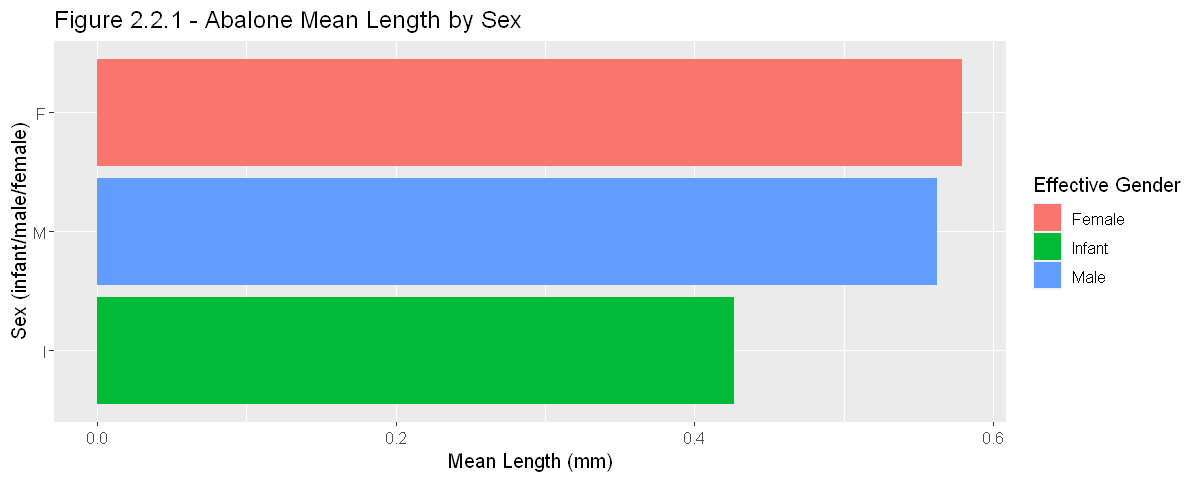

In [7]:
options(repr.plot.width = 10, repr.plot.height = 4)

abalone_graph_length <- abalone_summarize |>
        ggplot(aes(x = mean_length, 
                   y = fct_reorder(sex, mean_length),
                   fill = sex)) +
        geom_bar(stat = "identity") +
        labs(x = "Mean Length (mm)", y = "Sex (infant/male/female)", 
            title = "Figure 2.2.1 - Abalone Mean Length by Sex", fill = "Effective Gender") +
        scale_fill_discrete(labels = c("Female", "Infant", "Male")) +
        theme(text = element_text(size = 12))

abalone_graph_length

**Figure 2.2.1** - Bar graph observing the mean abalone length for each level of sex

- We can create similar graphs for our other factors of `diameter`, `height`, and `weight`:

In [8]:
options(repr.plot.width = 10, repr.plot.height = 4)

abalone_graph_diameter <- abalone_summarize |>
        ggplot(aes(x = mean_diameter, 
                   y = fct_reorder(sex, mean_diameter),
                   fill = sex)) +
        geom_bar(stat = "identity") +
        labs(x = "Mean Diameter (mm)", y = "Sex (infant/male/female)", 
            title = "Figure 2.2.2 - Abalone Mean Diameter by Sex", fill = "Effective Gender") +
        scale_fill_discrete(labels = c("Female", "Infant", "Male")) +
        theme(text = element_text(size = 12))

abalone_graph_height <- abalone_summarize |>
        ggplot(aes(x = mean_height, 
                   y = fct_reorder(sex, mean_height),
                   fill = sex)) +
        geom_bar(stat = "identity") +
        labs(x = "Mean Height (mm)", y = "Sex (infant/male/female)", 
            title = "Figure 2.2.3 - Abalone Mean Height by Sex", fill = "Effective Gender") +
        scale_fill_discrete(labels = c("Female", "Infant", "Male")) +
        theme(text = element_text(size = 12))

abalone_graph_weight <- abalone_summarize |>
        ggplot(aes(x = mean_weight, 
                   y = fct_reorder(sex, mean_weight),
                   fill = sex)) +
        geom_bar(stat = "identity") +
        labs(x = "Mean Weight (grams)", y = "Sex (infant/male/female)", 
            title = "Figure 2.2.4 - Abalone Mean Weight by Sex", fill = "Effective Gender") +
        scale_fill_discrete(labels = c("Female", "Infant", "Male")) +
        theme(text = element_text(size = 12))

* We can observe our visualizations:

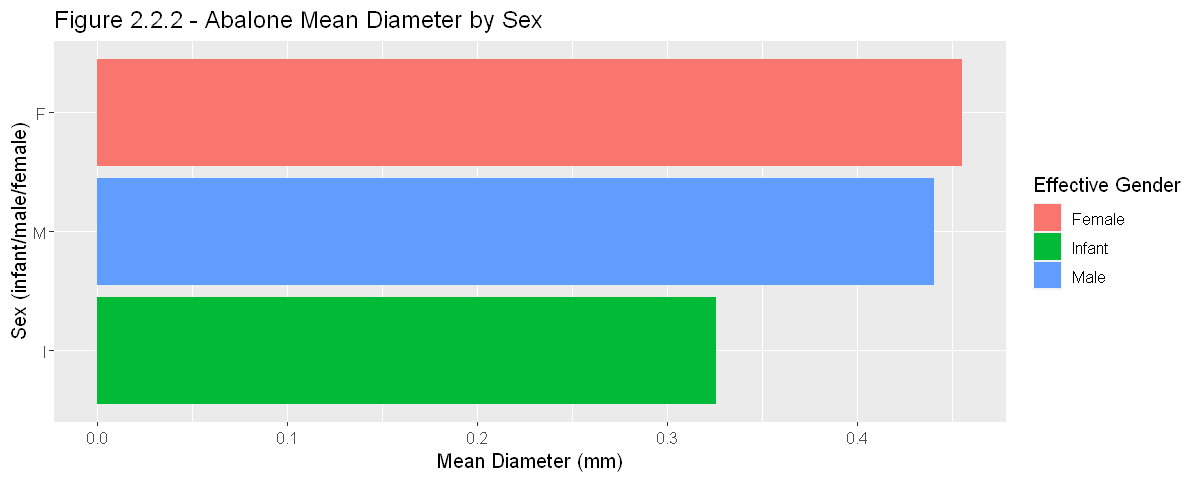

In [9]:
abalone_graph_diameter

**Figure 2.2.2** - Bar graph observing the mean abalone diameter for each level of sex

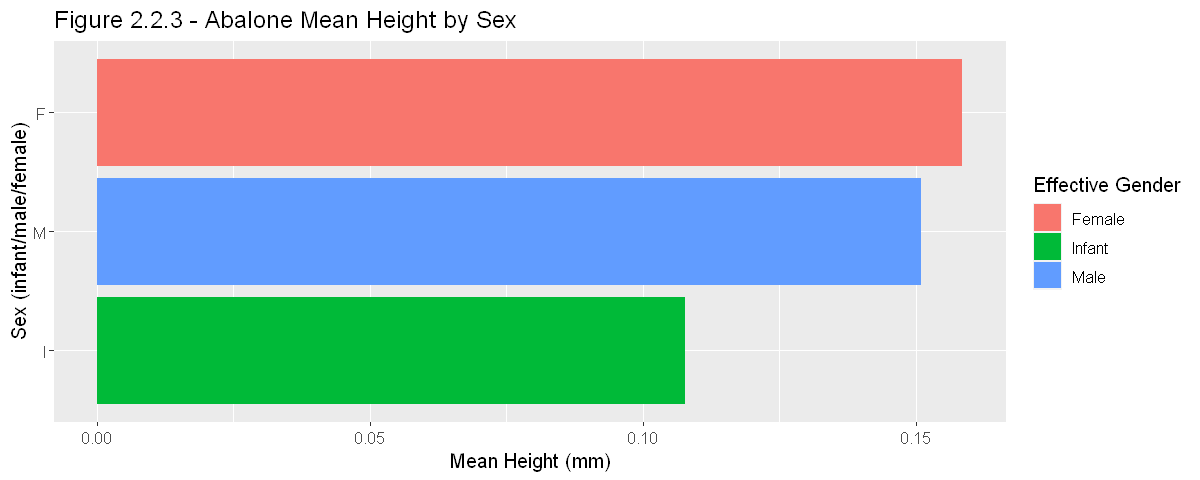

In [10]:
abalone_graph_height

**Figure 2.2.3** - Bar graph observing the mean abalone height for each level of sex

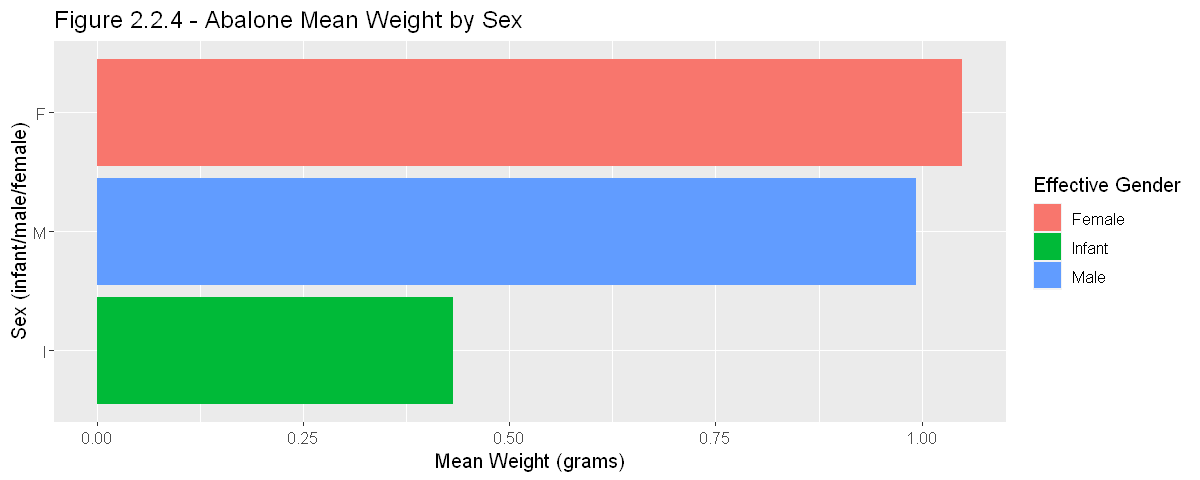

In [11]:
abalone_graph_weight

**Figure 2.2.4** - Bar graph observing the mean abalone weight for each level of sex

**What does this tell us about our the relationships between variables?**

- There is no effective relationship between the length, width, diameter, and weight variables in identifying whether the abalone is a female or a male. Based on the values in Table 1, there is approximately a 0.1 mm difference between the length of female and male abalones. Infants are smaller in all variables compared to female or male abalones.

    - So relating this to our question, we can see that our model may struggle to maintain a fair accuracy considering that the observations between female and male abalones are quite similar.

## 2.3 - Methods & Results - Classification

*Our data analysis will be performed using KNN classification. The steps we take are explored below:*

* Note that to beset build our model we should `tune` for the optimal value of $k$.
* We will start by intializing a `recipe`, predicting sex based on all 4 predictors and standardizing.
* Next we can develop our specifications, setting neighbours to `tune()`.

In [12]:
set.seed(3000)

abalone_recipe <- recipe(sex ~ length + diameter + height + weight, data = abalone_train) |> 
    step_scale(all_predictors()) |> 
    step_center(all_predictors()) 

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
    set_engine("kknn") |> 
    set_mode("classification") 

* We will perform 10-fold cross validation for our data, setting the strata around variable `sex`.
* Our $k$ options are stored in `k_vals` as a tibble below:

In [13]:
set.seed(3000)

abalone_vfold <- vfold_cv(abalone_train, v = 10, strata = sex) 

k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 1))

* We can `tune_grid` by placing the data we established above into a workflow, assigning our results to variable `knn_results`
* Once established, we can form a table of accuracies:

In [14]:
set.seed(3000)

knn_results <- workflow() |> 
    add_recipe(abalone_recipe) |> 
    add_model(knn_spec) |> 
    tune_grid(resamples = abalone_vfold, grid = k_vals) |> 
    collect_metrics()

accuracies <- knn_results |> 
    filter(.metric == "accuracy") |>
    arrange(by = desc(mean))

accuracies

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
42,accuracy,multiclass,0.5504716,10,0.008133204,Preprocessor1_Model042
43,accuracy,multiclass,0.5504634,10,0.007384486,Preprocessor1_Model043
44,accuracy,multiclass,0.5482300,10,0.006210236,Preprocessor1_Model044
⋮,⋮,⋮,⋮,⋮,⋮,⋮
3,accuracy,multiclass,0.5134656,10,0.008282002,Preprocessor1_Model003
1,accuracy,multiclass,0.4862935,10,0.006855395,Preprocessor1_Model001
2,accuracy,multiclass,0.4862935,10,0.006855395,Preprocessor1_Model002


* Since we sort the tibble using `arrange`, we can observe the optimal value of $k$ we should use against the testing set.
* We can also affirm our choice of $k$ is correct using a visualization:

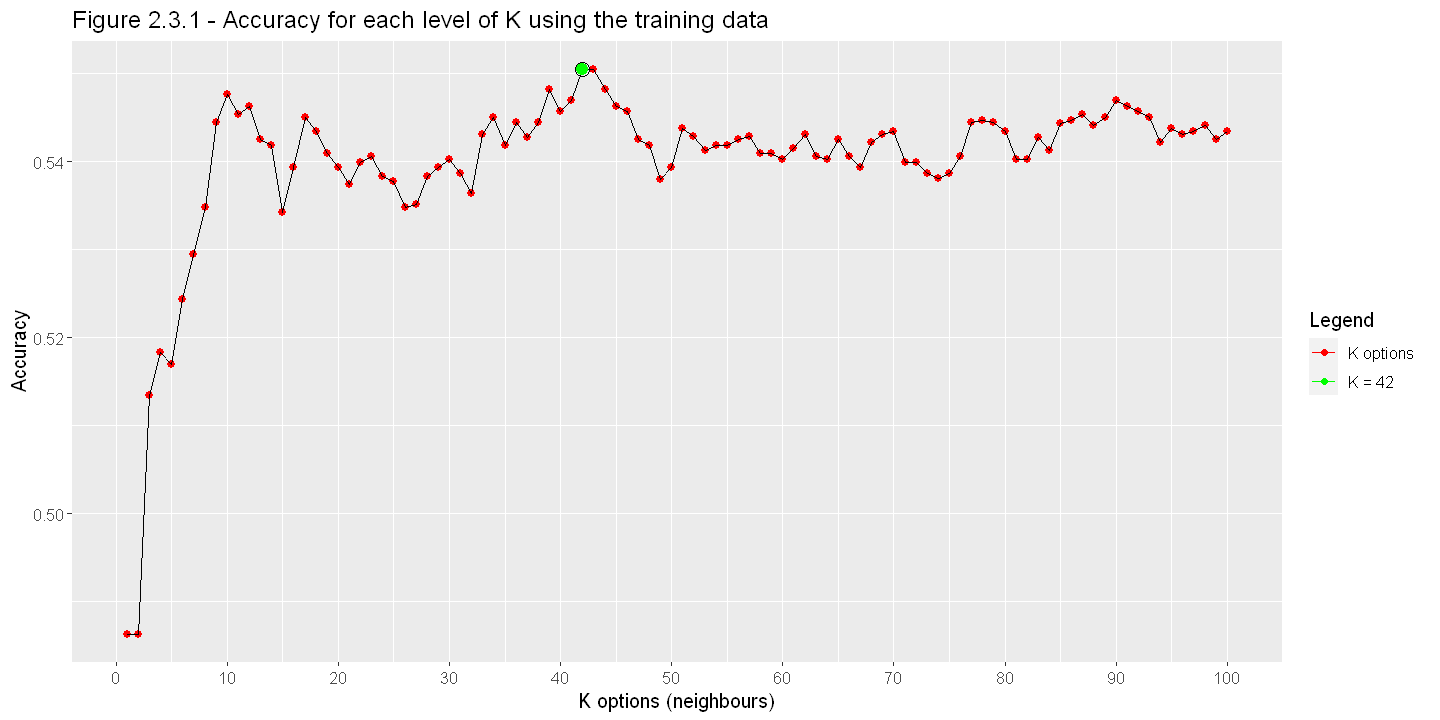

In [15]:
options(repr.plot.width = 12, repr.plot.height = 6)

accuracy_vs_k_plot <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point(aes(color = "red", size = 2)) +
  geom_line(aes(color = "black")) +
  geom_point(aes(x = 42, y = 0.5504716, color = "green", size = 3)) +
  geom_point(aes(x = 42, y = 0.5504716, colour = "black", size = 4), pch = 1) +
  labs(x = "K options (neighbours)", y = "Accuracy", 
      title="Figure 2.3.1 - Accuracy for each level of K using the training data") +
  scale_x_continuous(breaks = seq(0,100, by = 10)) +
  scale_color_identity(name = "Legend",
                       breaks = c("red", "green"),
                       labels = c("K options", "K = 42"),
                       guide = "legend") +
  scale_size_identity(name = "") +
  theme(text = element_text(size = 12))

accuracy_vs_k_plot

**Figure 2.3.1** - Plot of accuracy versus $K$.

*With our optimal value of $k$ discovered, we can now run our model against the testing data with the optimal $k$.*
- We can reuse our `recipe` (although it is shown again here to remind the reader), and we are to create a new `spec` with the correct value of $k$.
- With those established, we can put it into a `workflow` and make our predictions.

In [16]:
set.seed(3000)

abalone_recipe <- recipe(sex ~ length + diameter + height + weight, data = abalone_train) |> 
    step_scale(all_predictors()) |> 
    step_center(all_predictors())

tuned_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 42) |> # notice we load the new value of K here
    set_engine("kknn") |> 
    set_mode("classification") 

tuned_fit <- workflow() |> 
    add_recipe(abalone_recipe) |> 
    add_model(tuned_spec) |>
    fit(data = abalone_train)

abalone_predictions <- predict(tuned_fit, abalone_test) |> 
    bind_cols(abalone_test)

- Using those results, we can manipulate the resulting dataframe, `abalone_predictions`, and `pull()` to conclude our accuracy:

In [17]:
test_accuracy <- abalone_predictions |> 
    metrics(truth = sex, estimate = .pred_class) |> 
    filter(.metric == "accuracy") |>
    select(.estimate) |>
    pull()

test_accuracy

[1] 0.5492823

**What does this mean / why did this happen?**

* Our  test accuracy of $54.9\%$ was lower than our expected accuracy of around $80\%$. 
    * This accuracy could be due to using the wrong method to classify our abalone since KNN classification takes a long time to load large data sets.
    * Additionally, variables that are related to each other may produce similar results. For example, *in our case*, the factors of `diameter` and `weight` may be related (a larger abalone *may* result in a heavier weight measurement)

## 2.4 - Method & Results - Visualization

*In this section, we will perform two forms of visualization - histograms and bar graphs.*

*First are the histograms:*

* We will first aim to explore just how much each factor differs by sex. We can first make a histogram for the factor of `length`:

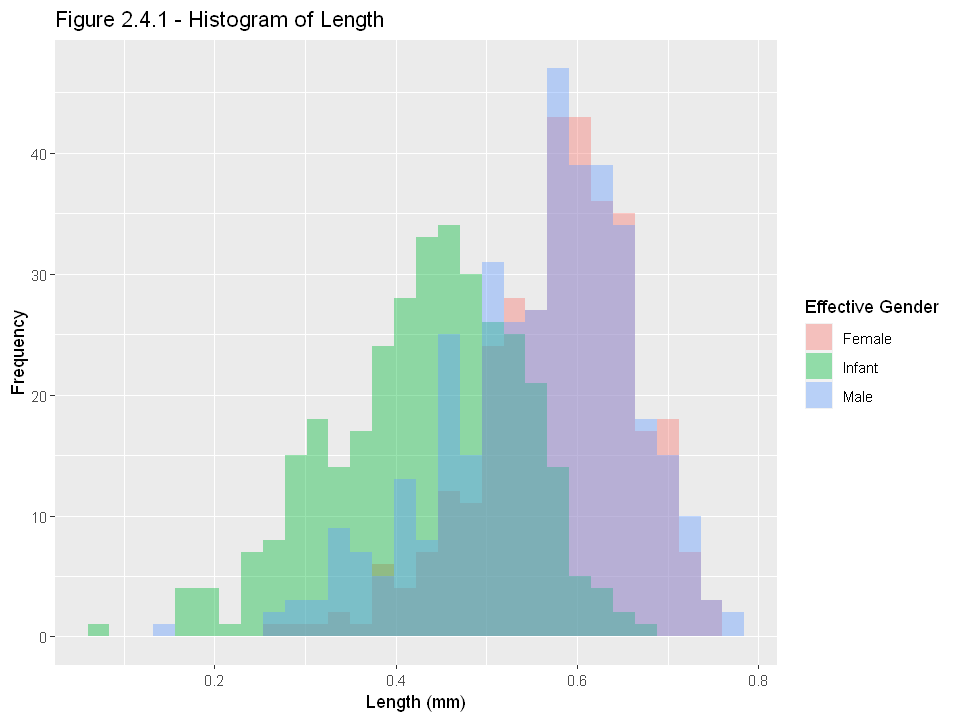

In [18]:
options(repr.plot.width = 8, repr.plot.height = 6)

length_hist <- abalone_test |>
    ggplot(aes(x = length, fill = sex)) +
    geom_histogram(position = "identity", alpha = 0.4, bins = 30) +
    labs(x = "Length (mm)", y = "Frequency", 
        title = "Figure 2.4.1 - Histogram of Length", fill = "Effective Gender") +
    scale_fill_discrete(labels = c("Female", "Infant", "Male"))

length_hist

**Figure 2.4.1** - Histogram demonstrating the counts for values of length, coloured by effective gender.

* We observe that the female and male categories (red and blue, respectively) appear to have quite a significant amount of overlap, suggesting it may be difficult for our algorithm to determine which is which.
* Conversely, abalone recorded as infants (in green) appear to have their own unique peak, meaning that using KNN methods are more likely to produce conclusive results.

* We can do the same for our other factors of `diameter`, `height`, and `weight`. 
* All of them show similar results and we will show the histogram for `weight` here:

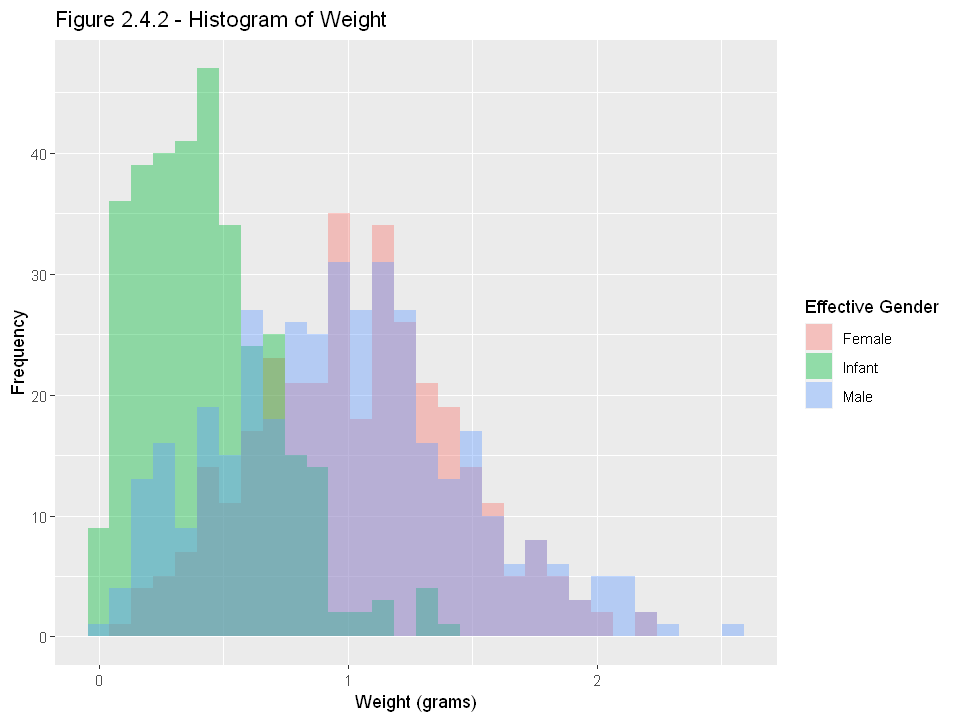

In [19]:
options(repr.plot.width = 8, repr.plot.height = 6)

weight_hist <- abalone_test |>
    ggplot(aes(x = weight, fill = sex)) +
    geom_histogram(position = "identity", alpha = 0.4, bins = 30) +
    labs(x = "Weight (grams)", y = "Frequency", 
         title = "Figure 2.4.2 - Histogram of Weight", fill = "Effective Gender") +
    scale_fill_discrete(labels = c("Female", "Infant", "Male"))

weight_hist

**Figure 2.4.2** - Histogram demonstrating the frequency of various weight measurements, coloured by effective gender.

**What might this signal regarding the accuracy of our algorithm?**

* These histograms appear to show a similar pattern – heavy overlap between female and male categories with the infant categories having their unique shape. This would suggest that our model can predict infants with sufficient accuracy but struggles when differentiating between female and male abalones. 
* All four histograms demonstrated the principles outlined above. Only two are shown here for the sake of concision.

*We can now perform further exploration through the use of bar graphs:*

* We can visualize how well each level of gender was predicted.
* First we will create a tibble which obtains the number of **correct guesses** by gender:

In [20]:
set.seed(3000)

correct_count_by_gender <- abalone_predictions |>
    mutate(correct = (.pred_class == sex)) |>
    group_by(sex) |>
    add_count() |>
    filter(correct == TRUE) |>
    summarize(correct = n())

correct_count_by_gender

sex,correct
<fct>,<int>
F,104
I,287
M,183


**Table 2.4.1** - tibble showing the number of correct predictions made for each level of sex

* We will then create a separate tibble which will count the **total number** of predictions by gender below.
* The total number of predictions is stored in column `n`.

In [21]:
prediction_count_by_gender <- abalone_predictions |>
    rename(total_sex = sex) |> # renamed to avoid duplicate name conflicts
    group_by(total_sex) |>
    count()

prediction_count_by_gender

total_sex,n
<fct>,<int>
F,327
I,336
M,382


**Table 2.4.2** - tibble showing the total number of predictions made for each level of sex

* Both tibbles can then be combined and tidied:

In [22]:
accuracy_by_gender <- bind_cols(correct_count_by_gender, prediction_count_by_gender) |>
    select(sex, correct, n) |>
    mutate(accuracy = (correct / n)*100)

accuracy_by_gender

sex,correct,n,accuracy
<fct>,<int>,<int>,<dbl>
F,104,327,31.80428
I,287,336,85.41667
M,183,382,47.90576


**Table 2.4.3** - table which shows the number of correct guesses, total number of guesses, and accuracy (expressed as a percentage)

* We can visualize this to better tie into our initial question:

*Can we accurately predict the effective gender of a given abalone using factors of length, diameter, height, and weight?*

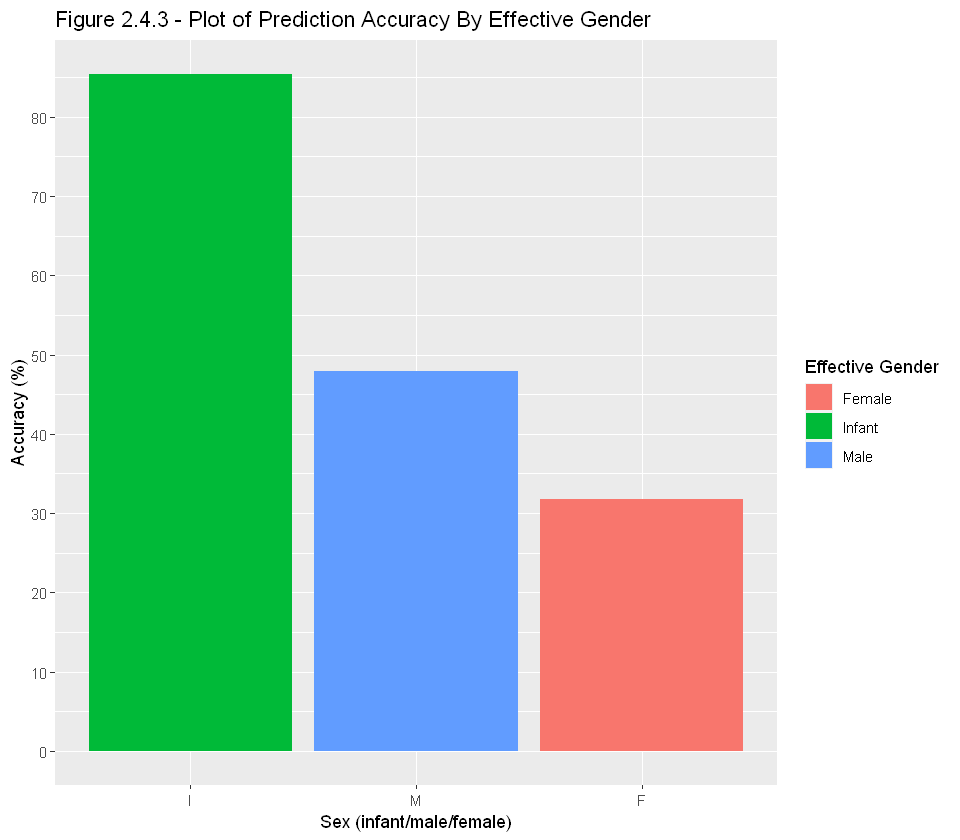

In [23]:
options(repr.plot.width = 8, repr.plot.height = 7)

accuracy_by_gender_plot <- accuracy_by_gender |>
    ggplot(aes(x = fct_reorder(sex, accuracy, .desc = TRUE), 
               y = accuracy, 
               fill = sex)) +
    geom_bar(stat = "identity") +
    labs(x = "Sex (infant/male/female)", y = "Accuracy (%)", 
         title = "Figure 2.4.3 - Plot of Prediction Accuracy By Effective Gender",
         fill = "Effective Gender") +
    scale_fill_discrete(labels = c("Female", "Infant", "Male")) +
    scale_y_continuous(breaks = seq(from = 0, to = 100, by = 10))

accuracy_by_gender_plot

**Figure 2.4.3** - Bar graph visualizing the prediction accuracy for each level of sex

* The answer, then, to our question would depend on the gender being considered: the model can predict infants with sufficient accuracy $(85.42\%)$, but will struggle when predicting between female $(31.80\%)$ and male $(47.91\%)$ abalones.

## 3 - Discussion

**What did we find?**
* Based on the analysis of the data and the accuracy of our model, we conclude that the four factors we chose were not a good predictors of an abalone’s gender category.
* Due to the nature of our data, KNN modeling is may not be a reliable method of predicting the gender of an abalone.
    * Although it was sufficiently accurate with infants, our model was not reliable when differentiating between female/male abalones.

**Is this what we expected to find?**
* This is not what we expected to find, we were expecting a much higher accuracy statistic when using our model against the testing data.

**What impact could such findings have?**
* Encourage the search for a better method of predicting the gender of abalones
* More efficiently classify new abalones only using their dimension data (diameter, weight, etc.) instead of having to analyze their organs.


**What future questions could this lead to?**
* Best location/place to find greatest the population of a specific gender of abalone?
* What are the characteristics of abalones tagged expensive (what are the most significant metrics merchants use to price the abalones)?

## 4. References

Anderson, G. (2003, Oct 27). *Abalone: Reproduction and growth.* Marine Bio. https://www.marinebio.net/marinescience/06future/abrepro.htm.

Bradley, R. (2010, Mar 9). *How to sex an abalone: A sea snail's story.* The Atlantic. https://www.theatlantic.com/health/archive/2010/03/how-to-sex-an-abalone-a-sea-snails-story/37198/.

Chernick, M. (2012, Sept 28). *Low classification accuracy, what to do next?* Cross Validated. https://stats.stackexchange.com/questions/38218/low-classification-accuracy-what-to-do-next.

Lutz, C. G. (2022, Apr). *Abalone.* Agricultural Marketing Resource Center. https://www.agmrc.org/commodities-products/aquaculture/aquaculture-non-fish-species/abalone.

Newman D., Hettich S., Blake C., Merz C. (1998). *Abalone Data Set.* UCI Repository of machine learning databases. https://archive.ics.uci.edu/ml/datasets/abalone. 